# Part 1: Stereo

In [12]:
# problem1.py

import numpy as np
from numpy.linalg import norm

def cost_ssd(patch1, patch2):
    """Compute the Sum of Squared Pixel Differences (SSD):

    Args:
        patch1: input patch 1 as (m, m) numpy array
        patch2: input patch 2 as (m, m) numpy array

    Returns:
        cost_ssd: the calcuated SSD cost as a floating point value
    """

    # START your code here
    # NOTE: You should remove the next line while coding
    # cost_ssd = -1
    cost_ssd = np.sum((patch1 - patch2) ** 2)
    # END your code here
    assert np.isscalar(cost_ssd)
    return cost_ssd


def cost_nc(patch1, patch2):
    """Compute the normalized correlation cost (NC):

    Args:
        patch1: input patch 1 as (m, m) numpy array
        patch2: input patch 2 as (m, m) numpy array

    Returns:
        cost_nc: the calculated NC cost as a floating point value
    """

    # START your code here
    # HINT: You can use the norm() function imported from numpy.linalg
    # NOTE: You should remove the next line while coding
    # cost_nc = -1
    patch1_flat = patch1.reshape(-1)
    patch2_flat = patch2.reshape(-1)
    # Euclidean norms of the flattened patches:
    norm_patch1 = np.linalg.norm(patch1_flat)
    norm_patch2 = np.linalg.norm(patch2_flat)
    # normalized correlation : dot product of the normalized vectors
    cost_nc = np.dot(patch1_flat, patch2_flat) / (norm_patch1 * norm_patch2)
    # END your code here
    assert np.isscalar(cost_nc)
    return cost_nc


def cost_function(patch1, patch2, alpha):
    """Compute the cost between two input window patches:
    Args:
        patch1: input patch 1 as (m, m) numpy array
        patch2: input patch 2 as (m, m) numpy array
        alpha: the weighting parameter for the cost function
    Returns:
        cost_val: the calculated cost value as a floating point value
    """
    assert patch1.shape == patch2.shape

    # START your code here
    # NOTE: You should remove the next line while coding
    # cost_val = -1

    # SSD and NC costs:
    ssd_cost = cost_ssd(patch1, patch2)
    nc_cost = cost_nc(patch1, patch2)
    # weighted sum of two cost functions:
    cost_val = (1 / patch1.size) * ssd_cost + alpha * nc_cost
    # END your code here
    assert np.isscalar(cost_val)
    return cost_val


def pad_image(input_img, window_size, padding_mode='symmetric'):
    """Output the padded image

    Args:
        input_img: an input image as a numpy array
        window_size: the window size as a scalar value, odd number
        padding_mode: the type of padding scheme, among 'symmetric', 'reflect', or 'constant'

    Returns:
        padded_img: padded image as a numpy array of the same type as image
    """
    assert np.isscalar(window_size)
    assert window_size % 2 == 1

    # START your code here
    # HINT: You can use the np.pad() function with mode=padding_mode
    # NOTE: You should remove the next line while coding
    # padded_img = input_img.copy()

    # Compute padding size (half of the window size)
    pad_size = window_size // 2
    # Pad the image using the specified padding mode
    padded_img = np.pad(input_img, pad_size, mode=padding_mode)
    # END your code here
    return padded_img


def compute_disparity(padded_img_l, padded_img_r, max_disp, window_size, alpha):
    """Compute the disparity map by using the window-based matching:
    Args:
        padded_img_l: The padded left-view input image as 2-dimensional numpy array
        padded_img_r: The padded right-view input image as 2-dimensional numpy array
        max_disp: the maximum disparity as a search range
        window_size: the patch size for window-based matching, odd number
        alpha: the weighting parameter for the cost function
    Returns:
        disparity: numpy array (H,W) of the same size as the input image without padding
    """
    assert padded_img_l.ndim == 2
    assert padded_img_r.ndim == 2
    assert padded_img_l.shape == padded_img_r.shape
    assert max_disp > 0
    assert window_size % 2 == 1

    # START your code here
    # HINT: in numpy, there is a function named argmin
    # NOTE: You should remove the next line while coding
    # disparity = padded_img_l.copy()
    height, width = padded_img_l.shape
    disparity = np.zeros((height - window_size + 1, width - window_size + 1))

    # Loop over every pixel in the image (excluding the padded border)
    for y in range(window_size // 2, height - window_size // 2):
        for x in range(window_size // 2, width - window_size // 2):
            min_cost = float('inf')
            best_disp = 0
            # search along the horizontal scan line within max_disp range
            for d in range(max_disp):
                if x - d < window_size // 2:  # stay within bounds
                    continue

                # Extract the patches from the left and right images
                patch_left = padded_img_l[y - window_size // 2:y + window_size // 2 + 1,
                                          x - window_size // 2:x + window_size // 2 + 1]
                patch_right = padded_img_r[y - window_size // 2:y + window_size // 2 + 1,
                                           x - d - window_size // 2:x - d + window_size // 2 + 1]

                # cost for this disparity and patch pair
                cost = cost_function(patch_left, patch_right, alpha)
                # minimum cost
                if cost < min_cost:
                    min_cost = cost
                    best_disp = d

            disparity[y - window_size // 2, x - window_size // 2] = best_disp
    # END your code here
    assert disparity.ndim == 2
    return disparity


def compute_aepe(disparity_gt, disparity_res):
    """Compute the average end-point error of the estimated disparity map:

    Args:
        disparity_gt: the ground truth of disparity map as (H, W) numpy array
        disparity_res: the estimated disparity map as (H, W) numpy array

    Returns:
        aepe: the average end-point error as a floating point value
    """
    assert disparity_gt.ndim == 2
    assert disparity_res.ndim == 2
    assert disparity_gt.shape == disparity_res.shape

    # START your code here
    # NOTE: You should remove the next line while coding
    # aepe = -1
    # average error (AEPE): absolute error between the ground truth and estimated disparity:
    aepe = np.mean(np.abs(disparity_gt - disparity_res))
    # END your code here
    assert np.isscalar(aepe)
    return aepe


def optimal_alpha():
    """Return alpha that leads to the smallest EPE
    (w.r.t. other values)"""
    # TODO: You need to fix the alpha value
    # alpha = np.random.choice([-0.06, -0.01, 0.04, 0.1])
    # return alpha
    alpha_values = [-0.06, -0.01, 0.04, 0.1]
    best_alpha = alpha_values[0]
    min_epe = float('inf')

    # AEPE for each alpha:
    for alpha in alpha_values:
        im_l = rgb2gray(load_image("part1_left.png"))
        im_r = rgb2gray(load_image("part1_right.png"))
        disparity_gt = disparity_read("part1_gt.png")

        padded_img_l = pad_image(im_l, window_size=11)
        padded_img_r = pad_image(im_r, window_size=11)
        disparity_res = compute_disparity(padded_img_l, padded_img_r, max_disp=15, window_size=11, alpha=alpha)

        aepe = compute_aepe(disparity_gt, disparity_res)
        print(f"Current Alpha: {alpha}, Current AEPE: {aepe}")
        if aepe < min_epe:
            min_epe = aepe
            best_alpha = alpha

    return best_alpha


Current Alpha: -0.06, Current AEPE: 0.9851947749426605
Current Alpha: -0.01, Current AEPE: 0.9891379820097477
Current Alpha: 0.04, Current AEPE: 0.9951440653669725
Current Alpha: 0.1, Current AEPE: 1.005310618549312
Alpha: -0.060
AEPE: 0.985


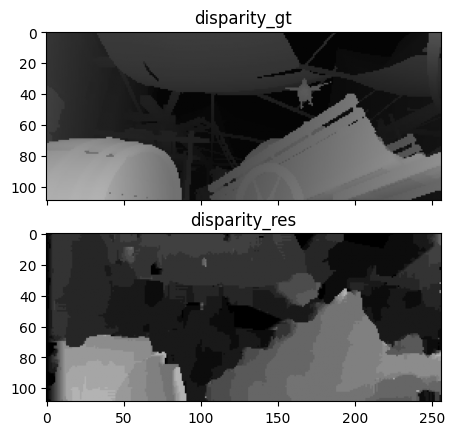

In [13]:
# main_stereo.py:

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
# Stereo

def rgb2gray(im):
    return np.mean(im, -1)


def load_image(path):
    return plt.imread(path)


def disparity_read(filename):
    """ Return disparity read from filename. """
    f_in = np.array(Image.open(filename))
    d_r = f_in[:,:,0].astype('float64')
    d_g = f_in[:,:,1].astype('float64')
    d_b = f_in[:,:,2].astype('float64')

    disparity = d_r * 4 + d_g / (2**6) + d_b / (2**14)
    return disparity


def problem1():
    """Example code implementing the steps in Problem 1"""

    # Given parameter. No need to change
    max_disp = 15

    alpha = optimal_alpha()
    print("Alpha: {:4.3f}".format(alpha))

    # Window size. You can freely change, but it should be an odd number
    window_size = 11

    im_left = rgb2gray(load_image("part1_left.png"))
    im_right = rgb2gray(load_image("part1_right.png"))
    disparity_gt = disparity_read("part1_gt.png")

    padded_img_l = pad_image(im_left, window_size, padding_mode='symmetric')
    padded_img_r = pad_image(im_right, window_size, padding_mode='symmetric')

    disparity_res = compute_disparity(padded_img_l, padded_img_r, max_disp, window_size, alpha)
    aepe = compute_aepe(disparity_gt, disparity_res)
    print("AEPE: {:4.3f}".format(aepe))

    _, axs = plt.subplots(nrows=2, sharex=True)
    axs[0].set_title('disparity_gt')
    axs[0].imshow(disparity_gt, vmin=0, vmax=20, cmap='gray')
    axs[1].set_title('disparity_res')
    axs[1].imshow(disparity_res, vmin=0, vmax=20, cmap='gray')
    plt.show()


problem1()


# Part 2: Optical Flow

In [15]:
# utils.py

# MIT License
#
# Copyright (c) 2018 Tom Runia
#
# Permission is hereby granted, free of charge, to any person obtaining a copy
# of this software and associated documentation files (the "Software"), to deal
# in the Software without restriction, including without limitation the rights
# to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
# copies of the Software, and to permit persons to whom the Software is
# furnished to do so, subject to conditions.
#
# Author: Tom Runia
# Date Created: 2018-08-03

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np


def make_colorwheel():
    '''
    Generates a color wheel for optical flow visualization as presented in:
        Baker et al. "A Database and Evaluation Methodology for Optical Flow" (ICCV, 2007)
        URL: http://vision.middlebury.edu/flow/flowEval-iccv07.pdf

    According to the C++ source code of Daniel Scharstein
    According to the Matlab source code of Deqing Sun
    '''

    RY = 15
    YG = 6
    GC = 4
    CB = 11
    BM = 13
    MR = 6

    ncols = RY + YG + GC + CB + BM + MR
    colorwheel = np.zeros((ncols, 3))
    col = 0

    # RY
    colorwheel[0:RY, 0] = 255
    colorwheel[0:RY, 1] = np.floor(255*np.arange(0,RY)/RY)
    col = col+RY
    # YG
    colorwheel[col:col+YG, 0] = 255 - np.floor(255*np.arange(0,YG)/YG)
    colorwheel[col:col+YG, 1] = 255
    col = col+YG
    # GC
    colorwheel[col:col+GC, 1] = 255
    colorwheel[col:col+GC, 2] = np.floor(255*np.arange(0,GC)/GC)
    col = col+GC
    # CB
    colorwheel[col:col+CB, 1] = 255 - np.floor(255*np.arange(CB)/CB)
    colorwheel[col:col+CB, 2] = 255
    col = col+CB
    # BM
    colorwheel[col:col+BM, 2] = 255
    colorwheel[col:col+BM, 0] = np.floor(255*np.arange(0,BM)/BM)
    col = col+BM
    # MR
    colorwheel[col:col+MR, 2] = 255 - np.floor(255*np.arange(MR)/MR)
    colorwheel[col:col+MR, 0] = 255
    return colorwheel


def flow_compute_color(u, v, convert_to_bgr=False):
    '''
    Applies the flow color wheel to (possibly clipped) flow components u and v.

    According to the C++ source code of Daniel Scharstein
    According to the Matlab source code of Deqing Sun

    :param u: np.ndarray, input horizontal flow
    :param v: np.ndarray, input vertical flow
    :param convert_to_bgr: bool, whether to change ordering and output BGR instead of RGB
    :return:
    '''

    flow_image = np.zeros((u.shape[0], u.shape[1], 3), np.uint8)

    colorwheel = make_colorwheel()  # shape [55x3]
    ncols = colorwheel.shape[0]

    rad = np.sqrt(np.square(u) + np.square(v))
    a = np.arctan2(-v, -u)/np.pi

    fk = (a+1) / 2*(ncols-1)
    k0 = np.floor(fk).astype(np.int32)
    k1 = k0 + 1
    k1[k1 == ncols] = 0
    f = fk - k0

    for i in range(colorwheel.shape[1]):

        tmp = colorwheel[:,i]
        col0 = tmp[k0] / 255.0
        col1 = tmp[k1] / 255.0
        col = (1-f)*col0 + f*col1

        idx = (rad <= 1)
        col[idx]  = 1 - rad[idx] * (1-col[idx])
        col[~idx] = col[~idx] * 0.75   # out of range?

        # Note the 2-i => BGR instead of RGB
        ch_idx = 2-i if convert_to_bgr else i
        flow_image[:,:,ch_idx] = np.floor(255 * col)

    return flow_image


def flow_to_color(flow_uv, clip_flow=None, convert_to_bgr=False):
    '''
    Expects a two dimensional flow image of shape [H,W,2]

    According to the C++ source code of Daniel Scharstein
    According to the Matlab source code of Deqing Sun

    :param flow_uv: np.ndarray of shape [H,W,2]
    :param clip_flow: float, maximum clipping value for flow
    :return:
    '''

    assert flow_uv.ndim == 3, 'input flow must have three dimensions'
    assert flow_uv.shape[2] == 2, 'input flow must have shape [H,W,2]'

    if clip_flow is not None:
        flow_uv = np.clip(flow_uv, -clip_flow, clip_flow)

    u = flow_uv[:,:,0]
    v = flow_uv[:,:,1]

    rad = np.sqrt(np.square(u) + np.square(v))
    rad_max = np.max(rad)

    epsilon = 1e-5
    u = u / (rad_max + epsilon)
    v = v / (rad_max + epsilon)

    return flow_compute_color(u, v, convert_to_bgr)


In [18]:
# problem2.py

import numpy as np
from scipy import interpolate
from scipy.signal import convolve2d
from functools import partial
conv2d = partial(convolve2d, mode="same", boundary="symm")

def compute_derivatives(im1, im2):
    """Compute dx, dy and dt derivatives.

    Args:
        im1: first image
        im2: second image

    Returns:
        Ix, Iy, It: derivatives of im1 w.r.t. x, y and t
    """
    assert im1.shape == im2.shape

    # START your code here
    # HINT: You can use the conv2d defined in Line 5 for convolution operations
    # NOTE: You should remove the next three lines while coding
    # Ix = np.empty_like(im1)
    # Iy = np.empty_like(im1)
    # It = np.empty_like(im1)
    dx_kernel = np.array([[-1, 1], [-1, 1]]) * 0.5
    dy_kernel = np.array([[-1, -1], [1, 1]]) * 0.5
    dt_kernel = np.ones((2, 2)) * 0.25
    Ix = conv2d(im1, dx_kernel) + conv2d(im2, dx_kernel)
    Iy = conv2d(im1, dy_kernel) + conv2d(im2, dy_kernel)
    It = conv2d(im2, dt_kernel) - conv2d(im1, dt_kernel)
    # END your code here

    assert Ix.shape == im1.shape and \
           Iy.shape == im1.shape and \
           It.shape == im1.shape

    return Ix, Iy, It

# consulted
def compute_motion(Ix, Iy, It, patch_size=15, aggregate="const", sigma=2.2):
    """Computes one iteration of optical flow estimation.

    Args:
        Ix, Iy, It: image derivatives w.r.t. x, y and t
        patch_size: specifies the side of the square region R in Eq. (1)
        aggregate: indicates whether to use Gaussian weighting
        sigma: if aggregate=='gaussian', use this sigma for the Gaussian kernel
    Returns:
        u: optical flow in x direction
        v: optical flow in y direction

    All outputs have the same dimensionality as the input
    """
    assert Ix.shape == Iy.shape and \
            Iy.shape == It.shape

    # START your code here
    # HINT: You can use the conv2d defined in Line 5 for convolution operations
    # NOTE: You can use either linear algebra knowledge or numpy.linalg.inv() for the matrix inverse
    # NOTE: You should remove the next two lines while coding
    # u = np.empty_like(Ix)
    # v = np.empty_like(Iy)
    half_size = patch_size // 2
    u = np.zeros_like(Ix)
    v = np.zeros_like(Iy)

    if aggregate == "gaussian":
        x = np.linspace(-half_size, half_size, patch_size)
        gauss_kernel = np.exp(-0.5 * (x / sigma) ** 2)
        weights = np.outer(gauss_kernel, gauss_kernel)
    else:
        weights = np.ones((patch_size, patch_size))

    for i in range(half_size, Ix.shape[0] - half_size):
        for j in range(half_size, Ix.shape[1] - half_size):
            Ix_patch = Ix[i-half_size:i+half_size+1, j-half_size:j+half_size+1]
            Iy_patch = Iy[i-half_size:i+half_size+1, j-half_size:j+half_size+1]
            It_patch = It[i-half_size:i+half_size+1, j-half_size:j+half_size+1]

            A = np.stack([Ix_patch.ravel(), Iy_patch.ravel()], axis=1)
            b = -It_patch.ravel()
            # Create the diagonal matrix W from the weights
            W = np.diag(weights.ravel())
            # Compute the matrix products
            AtW = A.T @ W
            AtWA = AtW @ A
            AtWb = AtW @ b
            # Solve for the flow if the matrix is invertible
            if np.linalg.det(AtWA) > 1e-6:
                flow = np.linalg.solve(AtWA, AtWb)
                u[i, j], v[i, j] = flow
    # END your code here
    assert u.shape == Ix.shape and \
            v.shape == Ix.shape
    return u, v


def warp(im, u, v):
    """Warping of a given image using provided optical flow.

    Args:
        im: input image
        u, v: optical flow in x and y direction

    Returns:
        im_warp: warped image (of the same size as input image)
    """
    assert im.shape == u.shape and \
            u.shape == v.shape

    # START your code here
    # HINT: You can use the np.meshgrid() function
    # HINT: You can use the interpolate.griddata() function with method='linear' and fill_value=0
    # NOTE: You should remove the next line while coding
    # im_warp = np.empty_like(im)
    h, w = im.shape
    x, y = np.meshgrid(np.arange(w), np.arange(h))
    x_new = np.clip(x + u, 0, w - 1)
    y_new = np.clip(y + v, 0, h - 1)
    im_warp = interpolate.griddata((y.ravel(), x.ravel()), im.ravel(), (y_new.ravel(), x_new.ravel()), method='linear', fill_value=0).reshape(h, w)
    # END your code here
    assert im_warp.shape == im.shape
    return im_warp


def compute_cost(im1, im2):
    """Implementation of the cost minimised by Lucas-Kanade."""
    assert im1.shape == im2.shape

    # START your code here
    # NOTE: You should remove the next line while coding
    # d = 0.0
    d = np.sum((im1 - im2) ** 2) / im1.size
    # END your code here
    assert isinstance(d, float)
    return d


The things example - aggregate='const': 


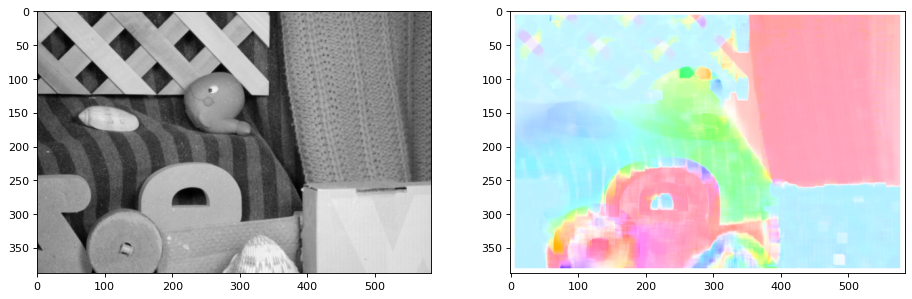

Cost: 5.946e-04

The things example - aggregate='gaussian': 


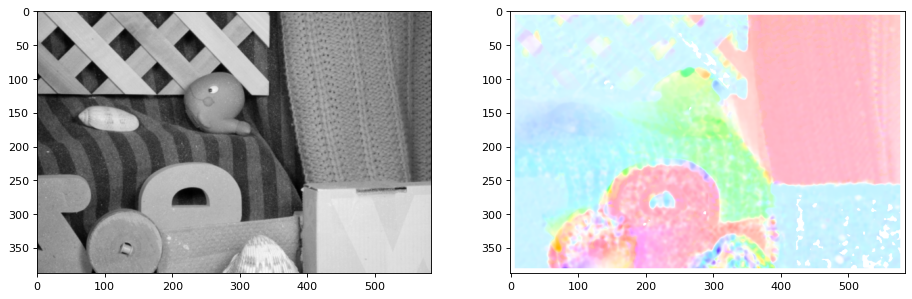

Cost: 5.621e-04

The street example - aggregate='const': 


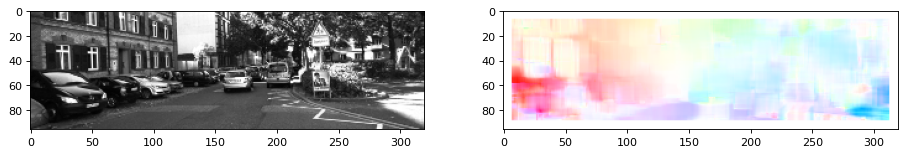

Cost: 3.157e-02

The street example - aggregate='gaussian': 


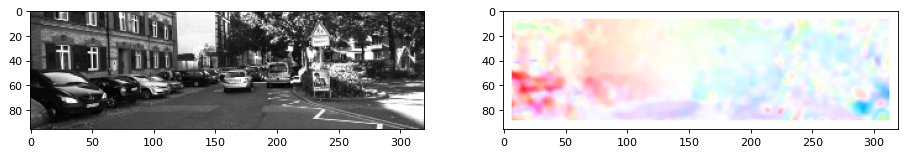

Cost: 2.953e-02



In [19]:
# main_flow.py

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
# from utils import *
# # Flow
# import problem2 as part2

def show_two(im1, im2):
    fig = plt.figure(figsize=(14, 6), dpi=80, facecolor='w', edgecolor='k')

    (ax1, ax2) = fig.subplots(1, 2)

    ax1.imshow(im1, cmap='gray')
    ax2.imshow(im2)

    plt.show()


def problem2(image1, image2, aggregate="const", sigma=2.2):
    # Loading the image and scaling to [0, 1]
    im1 = np.array(Image.open(image1).convert('L')) / 255.0
    im2 = np.array(Image.open(image2).convert('L')) / 255.0

    Ix, Iy, It = compute_derivatives(im1, im2)  # gradients
    u, v = compute_motion(Ix, Iy, It, aggregate=aggregate, sigma=sigma)  # flow

    # stacking for visualisation
    of = np.stack([u, v], axis=-1)
    # convert to RGB using wheel colour coding
    rgb_image = flow_to_color(of, clip_flow=5)
    # display
    show_two(im1, rgb_image)

    # warping 1st image to the second
    im1_warped = warp(im1, u, v)
    cost = compute_cost(im1_warped, im2)
    print("Cost: {:4.3e}".format(cost))


def problem2_start():
    # the things frames
    print ("The things example - aggregate='const': ")
    problem2("part2_things_frame1.png", "part2_things_frame2.png", aggregate="const")
    print ("")
    print ("The things example - aggregate='gaussian': ")
    problem2("part2_things_frame1.png", "part2_things_frame2.png", aggregate="gaussian", sigma=2.2)
    print ("")
    # the street frames
    print ("The street example - aggregate='const': ")
    problem2("part2_street_frame1.png", "part2_street_frame2.png", aggregate="const")
    print ("")
    print ("The street example - aggregate='gaussian': ")
    problem2("part2_street_frame1.png", "part2_street_frame2.png", aggregate="gaussian", sigma=2.2)
    print ("")


problem2_start()
